In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


from PyPDF2 import PdfMerger
from os import listdir
from os.path import isfile, join

2023-06-16 18:51:32.863367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 18:51:33.624545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wireplane = 'Z'

In [3]:
mean_np_AE_5_10 = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_'+wireplane+'_mean_adc_5_10.npy')
std_np_AE_5_10 = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_'+wireplane+'_std_adc_5_10.npy')

In [4]:
x_test = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_'+wireplane+'_x_test_adc_5_10.npy')
y_test = np.load('/home/vlian/Workspace/samples_for_train_low_adc/low_adc_'+wireplane+'_y_test_adc_5_10.npy')

In [5]:
x_test_scaled = (x_test-mean_np_AE_5_10)/std_np_AE_5_10
y_test_scaled = (y_test-mean_np_AE_5_10)/std_np_AE_5_10

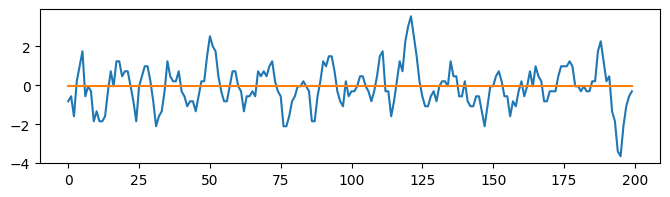

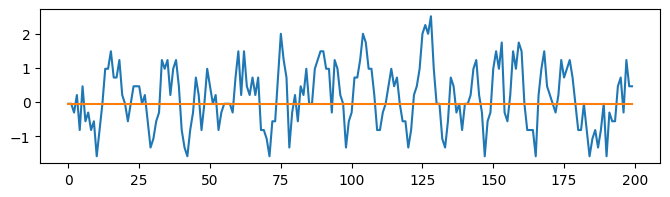

In [6]:
for i in range(2):
    plt.figure(figsize=(8,2))
    plt.plot(x_test_scaled[i])
    plt.plot(y_test_scaled[i])
    plt.show()

In [7]:
model = load_model('/home/vlian/Workspace/LArTPC-1DCNN-AutoEncoder/Neutrino-Trained-New-Dataset/AutoEncoder-Current/train_large_dataset/models/model_AE_12800_low_ADC_5_10'+wireplane+'plane_nu.h5')

2023-06-16 18:51:36.063822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-16 18:51:36.096193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-16 18:51:36.096251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-16 18:51:36.099192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-16 18:51:36.099246: I tensorflow/compile

In [8]:
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_


In [9]:
def eval_model(model, mean, std):

    predictions = model.predict(x_test_scaled, batch_size=4096)

    pred = predictions*std + mean

    print('labeling predictions...')
    pred_labels = [label_predictions(wave) for wave in pred]
    truth_labels = [label_truths(t_wave) for t_wave in y_test]

    fpr, tpr, thresholds = roc_curve(truth_labels, pred_labels, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)


    return pred, fpr, tpr, roc_auc

In [10]:
def get_snr(noisy, clean):
    p_c = np.mean(np.square(clean.astype(np.int32)))
    p_s = clean - noisy
    p_n = np.mean(np.square(p_s.astype(np.int32)))

    # Compute the SNR
    snr_linear = p_c / p_n

    return snr_linear

In [11]:
pred, fpr, tpr, roc_auc = eval_model(model, mean_np_AE_5_10, std_np_AE_5_10)

2023-06-16 18:51:37.914324: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320000000 exceeds 10% of free system memory.
2023-06-16 18:51:38.128216: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320000000 exceeds 10% of free system memory.
2023-06-16 18:51:39.929281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-16 18:51:41.130062: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


98/98 [==============================] - 4s 8ms/step


2023-06-16 18:51:42.507816: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320000000 exceeds 10% of free system memory.


labeling predictions...


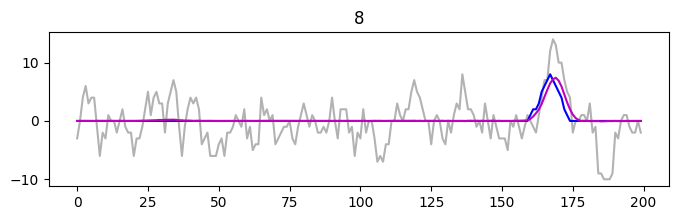

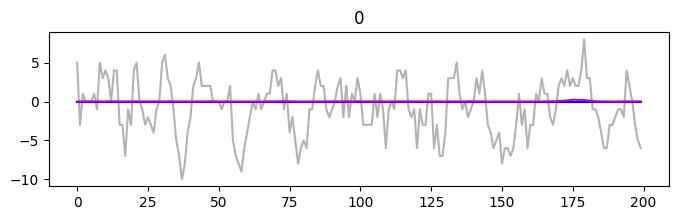

In [12]:
for i in range(10,12):
    plt.figure(figsize=(8,2))
    plt.title(max(y_test[i]))
    plt.plot(x_test[i], color='black', alpha=0.3)
    plt.plot(y_test[i], color='blue')
    plt.plot(pred[i], color='m')
    plt.show()

In [13]:
def get_by_adc(adc):
    x = []
    y = []
    p = []

    for i, wave in enumerate(y_test):
        if max(wave) == adc:
            x.append(x_test[i])
            y.append(wave)
            p.append(pred[i])
    return x, y, p

In [14]:
def make_single_pdf(wave_idx, pg_num, adc):
    
    x, y, p = get_by_adc(adc)

    fig, axs = plt.subplots(3,2, figsize=(20, 12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        wave_idx = index_

        snr = get_snr(x[index_], y[index_])
        snr = np.round(snr, 2)
        axes[i].set_title('clean sig. +peak amplitude: ' + str(int(max(y[index_]))) + ' --- snr: ' + str(snr),size=15)
        axes[i].plot(x[index_], color='black', alpha=0.3, label='input')
        axes[i].plot(y[index_], color='blue', alpha=0.9, label='truth')
        axes[i].plot(p[index_], color='m', alpha=0.7, label='pred')
        axes[i].legend(fontsize=12)
    


    plt.savefig('./tmp/tmp' +str(pg_num) + '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()
    #plt.plot()
    return wave_idx

In [15]:


# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, wireplane, adc):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, adc) + 1
        page_num += 1

    merger = PdfMerger()
    path = './tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    merger.write('./' + wireplane +'/' +wireplane+'_adc_' + str(adc) + '.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [16]:
for i in range(5, 11):
    make_complete_pdf(10, wireplane, i)
    print(i)

['./tmp/tmp8.pdf', './tmp/tmp9.pdf', './tmp/tmp7.pdf', './tmp/tmp4.pdf', './tmp/tmp5.pdf', './tmp/tmp1.pdf', './tmp/tmp6.pdf', './tmp/tmp0.pdf', './tmp/tmp3.pdf', './tmp/tmp2.pdf']
5
['./tmp/tmp8.pdf', './tmp/tmp9.pdf', './tmp/tmp7.pdf', './tmp/tmp4.pdf', './tmp/tmp5.pdf', './tmp/tmp1.pdf', './tmp/tmp6.pdf', './tmp/tmp0.pdf', './tmp/tmp3.pdf', './tmp/tmp2.pdf']
6
['./tmp/tmp8.pdf', './tmp/tmp9.pdf', './tmp/tmp7.pdf', './tmp/tmp4.pdf', './tmp/tmp5.pdf', './tmp/tmp1.pdf', './tmp/tmp6.pdf', './tmp/tmp0.pdf', './tmp/tmp3.pdf', './tmp/tmp2.pdf']
7
['./tmp/tmp8.pdf', './tmp/tmp9.pdf', './tmp/tmp7.pdf', './tmp/tmp4.pdf', './tmp/tmp5.pdf', './tmp/tmp1.pdf', './tmp/tmp6.pdf', './tmp/tmp0.pdf', './tmp/tmp3.pdf', './tmp/tmp2.pdf']
8
['./tmp/tmp8.pdf', './tmp/tmp9.pdf', './tmp/tmp7.pdf', './tmp/tmp4.pdf', './tmp/tmp5.pdf', './tmp/tmp1.pdf', './tmp/tmp6.pdf', './tmp/tmp0.pdf', './tmp/tmp3.pdf', './tmp/tmp2.pdf']
9
['./tmp/tmp8.pdf', './tmp/tmp9.pdf', './tmp/tmp7.pdf', './tmp/tmp4.pdf', './tmp/tmp5.